In [13]:
#Import libs
#Buit-in libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import statsmodels.api as sm
#Custom libs
#we import Washington_2019 for constructing the regression model, and import Washington_2018 for testing the 
#Performance of the model with the metrics of RMSE and R2 Square
from data_collection_plotting_2019 import Washington as Washington_2019 
from data_collection_plotting_2018 import Washington as Washington_2018
from data_collection_plotting_2018 import plotting_map, plotting_cluster
from sklearn.decomposition import PCA

1.Consturcting the dataset for regression. 

Y is the EV_number; X is indepent variables.

Training dataset is the dataset for obtianing the regression coefficients.

Test dataset is for evaluating the performance.

In [2]:
#1. Consturcting the dataset for regression. 
#Y:EV_number; X:indepent variables.

Y=Washington_2019.groupby('County')['EV_number'].mean()
X=Washington_2019.drop('geometry',axis=1)
X=X.drop('EV_number',axis=1)
X=X.groupby('County').mean()
county_name=Washington_2019['County'].to_numpy()
#Collect test data
Y_test=Washington_2018.groupby('County')['EV_number'].mean()
X_test=Washington_2018.drop('geometry',axis=1)
X_test=X_test.drop('EV_number',axis=1)
X_test=X_test.groupby('County').mean()


2.We need to do some preprocessing, i.e. Standarization for the X (no needs for Y)

In [3]:
#2. preprocessing: scaling the X-variables

scaler = StandardScaler()
scaler.fit(np.vstack([X.values,X_test.values]))
X_scaled = scaler.transform(X)
X_scaled_test=scaler.transform(X_test)

3.Regression based on MLR

1)We need to fit the MLR model based on our training dataset, i.e. X_scaled and Y

Then we can plot the regression coefficients. 

Hit: If the coeff is greather than 0 then the independent variable is positive corelated with the Y, vice vesa.


[  24.39846138   -5.05617131  -22.71160355   -8.32769832  -27.15150176
   42.3333994  1458.26419617 -589.93887913]


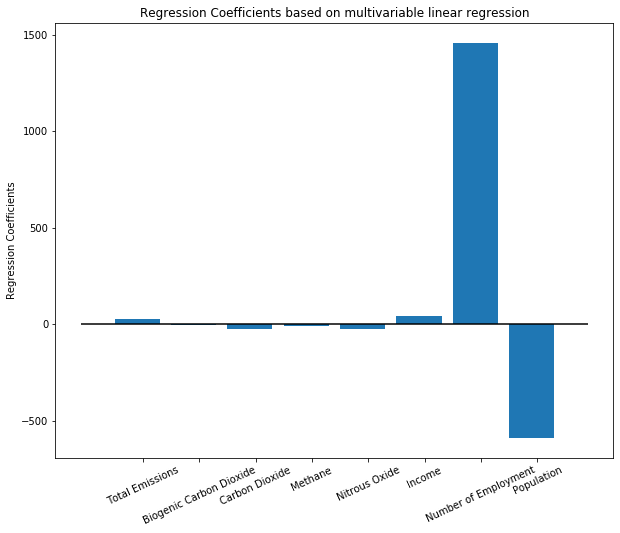

In [4]:
#3.Regression based on MLR
reg = LinearRegression().fit(X_scaled, Y.values)
# print the coefficients
print(reg.coef_)
# plot the regression coefficients
plt.figure(figsize=(10,8))
x = np.arange(len(reg.coef_))
plt.bar(x, height= reg.coef_)
plt.hlines(0,-1,8)
plt.xticks(x+.1, X.columns,fontsize=10, rotation=25)
plt.ylabel("Regression Coefficients")
plt.title('Regression Coefficients based on multivariable linear regression')
plt.savefig('Coeff_MLR.png')
plt.show()



2)We do prediction on the test dataset, i.e. X_scaled_test

We will get the plot for the performance with metrics of RMSE and R-square

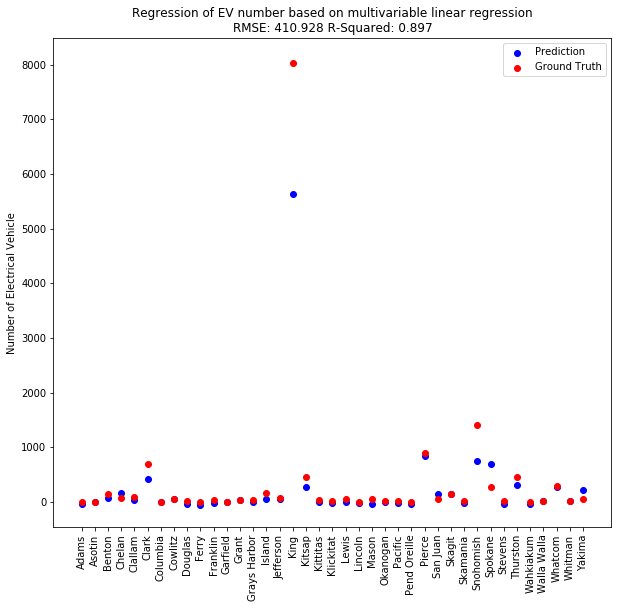

In [5]:
#Plotting the regression result
# predict the data
Y_predict = reg.predict(X_scaled_test)
RMSE_mlr=round(np.sqrt(MSE(Y_test,Y_predict)),3)
R2_mlr=round(R2(Y_test,Y_predict),3)

plt.figure(figsize=(10,9))
fig=plt.subplot(111)
fig_predict=fig.scatter(np.arange(len(Y_predict)),Y_predict,c='b')
fig_truth=fig.scatter(np.arange(len(Y_test)),Y_test,c='r')
fig.legend((fig_predict,fig_truth),('Prediction','Ground Truth'))
plt.xticks(np.arange(len(Y_test)), county_name, fontsize=10, rotation=90)
plt.ylabel('Number of Electrical Vehicle')
plt.title('Regression of EV number based on multivariable linear regression\n'+'RMSE: '+np.str(RMSE_mlr)+' R-Squared: '+np.str(R2_mlr))
plt.savefig('Result_MLR.png')
plt.show()

3)We also want the statistical test for our obtined regression coefficients, so I used 'statsmodels'.

As you can see from the table, there are several statistical parameters which are needed by your interpretation. Good luck!

PS: If you wanna plot out the table, just uncomment the comments code, but you may need to modify the 'mpi' for a better visulization. :)

In [6]:
#Statistics for MLR model
X_sm=sm.add_constant(X_scaled)
model=sm.OLS(Y,X_sm).fit()
print(model.summary())

coef_df = pd.DataFrame({'Variable name':np.hstack(['Const',X.columns.values]), #Add name for each variable
                        "params": model.params,   # regression coefficients
                        "std err": model.bse,     # Bse
                        "t": round(model.tvalues,3),       #T value
                        "p-values": round(model.pvalues,3) #P value                        
                       })

coef_df[['coef_0.025','coef_0.975']] = model.conf_int() # 回归系数置信区间 默认5%，括号中可填具体数字 比如0.05, 0.1
coef_df

#Plotting table if you needed
# fig=plt.figure(figsize=(10,6), dpi=1400)
# ax = fig.add_subplot(111,frame_on=False)
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# pd.plotting.table(ax, coef_df, loc='center')  
# plt.show()


                            OLS Regression Results                            
Dep. Variable:              EV_number   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     260.7
Date:                Wed, 08 Sep 2021   Prob (F-statistic):           1.48e-25
Time:                        10:41:38   Log-Likelihood:                -239.45
No. Observations:                  39   AIC:                             496.9
Df Residuals:                      30   BIC:                             511.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        263.7523     20.716     12.732      0.0

,Variable name,params,std err,t,p-values,coef_0.025,coef_0.975
const,Const,263.752293,20.716183,12.732,0.000,221.444203,306.060382
x1,Total Emissions,24.398461,366.914593,0.066,0.947,-724.941105,773.738028
x2,Biogenic Carbon Dioxide,-5.056171,178.755214,-0.028,0.978,-370.123022,360.010679
x3,Carbon Dioxide,-22.711604,306.529197,-0.074,0.941,-648.727740,603.304533
x4,Methane,-8.327698,30.025381,-0.277,0.783,-69.647707,52.992310
x5,Nitrous Oxide,-27.151502,21.725916,-1.250,0.221,-71.521742,17.218738
x6,Income,42.333399,29.844411,1.418,0.166,-18.617020,103.283819
x7,Number of Employment,1458.264196,109.141015,13.361,0.000,1235.368508,1681.159884
x8,Population,-589.938879,106.369979,-5.546,0.000,-807.175358,-372.702400


4. The same procedure for PCA-based Regression.

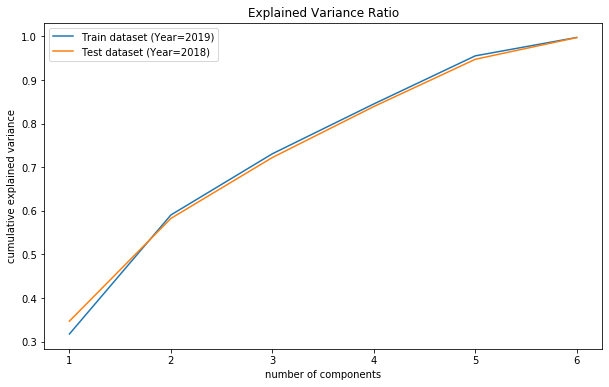

In [7]:
#Regression based on PCA-based Regression
#Execute a PCA on the X
from sklearn.decomposition import PCA
pca = PCA(6).fit(X_scaled)
pca1=PCA(6).fit(X_scaled_test)
# visualize the results
plt.figure(figsize=(10,6))
l1=plt.plot(np.arange(6)+1,np.cumsum(pca.explained_variance_ratio_))
l2=plt.plot(np.arange(6)+1,np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(['Train dataset (Year=2019)','Test dataset (Year=2018)'])
plt.title('Explained Variance Ratio')
plt.savefig('Explained_Variance.png')
plt.show()

# compute Loading P and Score T
P = pca.components_
T = X_scaled.dot(P.T)

[ 502.13770233  225.44977396   74.38607748   10.40482577  -18.13080777
 -231.16710463]
[ -0.90551975   9.93700779  -5.43045003 -12.12100721 -28.03387928
  94.16549086 416.34775364 423.20670522]


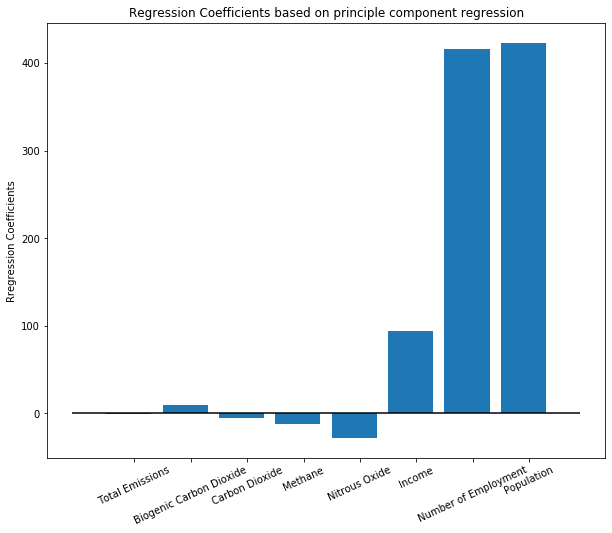

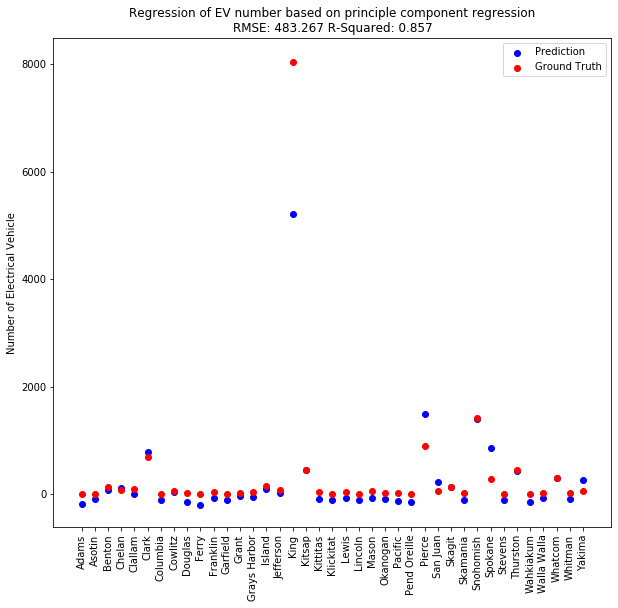

In [8]:
# train a PCR model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(T, Y.values)


print(reg.coef_)
coef_PCR=reg.coef_.dot(P)
print(coef_PCR)
# plot the regression coefficients
plt.figure(figsize=(10,8))
x = np.arange(len(coef_PCR))
plt.bar(x, height= coef_PCR)
plt.hlines(0,-1,8)
plt.xticks(x+.1, X.columns,fontsize=10, rotation=25)
plt.ylabel("Rregression Coefficients")
plt.title('Regression Coefficients based on principle component regression')
plt.savefig('Coeff_PCR.png')
plt.show()


# predict the y's and plot them against the measured y's
Y_predict = reg.predict(X_scaled_test.dot(P.T))
RMSE_pcr=round(np.sqrt(MSE(Y_test,Y_predict)),3)
R2_pcr=round(R2(Y_test,Y_predict),3)

plt.figure(figsize=(10,9))
fig=plt.subplot(111)
fig_predict=fig.scatter(np.arange(len(Y_predict)),Y_predict,c='b')
fig_truth=fig.scatter(np.arange(len(Y_test)),Y_test,c='r')
fig.legend((fig_predict,fig_truth),('Prediction','Ground Truth'))
plt.xticks(np.arange(len(Y_test)), county_name, fontsize=10, rotation=90)
plt.ylabel('Number of Electrical Vehicle')
plt.title('Regression of EV number based on principle component regression\n'+'RMSE: '+np.str(RMSE_pcr)+' R-Squared: '+np.str(R2_pcr))
plt.savefig('Result_PCR.png')
plt.show()

In [9]:
T_sm=sm.add_constant(T)
model=sm.OLS(Y,T_sm).fit()
print(model.summary())
coef_df = pd.DataFrame({'Variable name':['Const','PC 1','PC 2','PC 3','PC 4','PC 5','PC 6'], #Add name for each variable
                        "params": model.params,   # regression coefficients
                        "std err": model.bse,     # Bse
                        "t": round(model.tvalues,3),       #T value
                        "p-values": round(model.pvalues,3) #P value                        
                       })

coef_df[['coef_0.025','coef_0.975']] = model.conf_int() # 回归系数置信区间 默认5%，括号中可填具体数字 比如0.05, 0.1
coef_df

                            OLS Regression Results                            
Dep. Variable:              EV_number   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     86.26
Date:                Wed, 08 Sep 2021   Prob (F-statistic):           2.39e-18
Time:                        10:41:38   Log-Likelihood:                -267.00
No. Observations:                  39   AIC:                             548.0
Df Residuals:                      32   BIC:                             559.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        261.2335     40.618      6.431      0.0

,Variable name,params,std err,t,p-values,coef_0.025,coef_0.975
const,Const,261.233526,40.617930,6.431,0.000,178.497510,343.969543
x1,PC 1,502.137702,24.295212,20.668,0.000,452.649974,551.625431
x2,PC 2,225.449774,26.213961,8.600,0.000,172.053682,278.845866
x3,PC 3,74.386077,36.565165,2.034,0.050,-0.094727,148.866881
x4,PC 4,10.404826,40.504907,0.257,0.799,-72.100971,92.910622
x5,PC 5,-18.130808,41.238588,-0.440,0.663,-102.131063,65.869448
x6,PC 6,-231.167105,66.676043,-3.467,0.002,-366.981760,-95.352449


5.As you required the Coorelation matrix

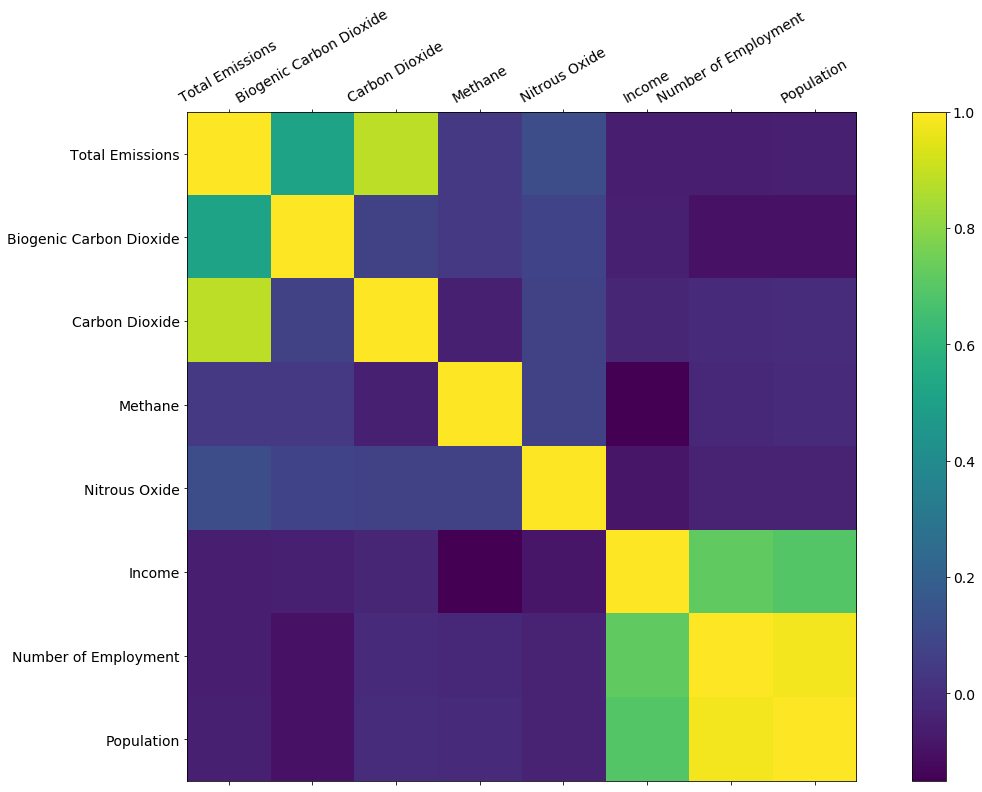

In [10]:

# plot the correlation matrix
f = plt.figure(figsize=(20, 12))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(range(X.shape[1]), X.columns, fontsize=14, rotation=30)
plt.yticks(range(X.shape[1]), X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.savefig('Corr_X.png')
plt.show()

6. K-means.

I chose 5 class at the end, but you can modify it.

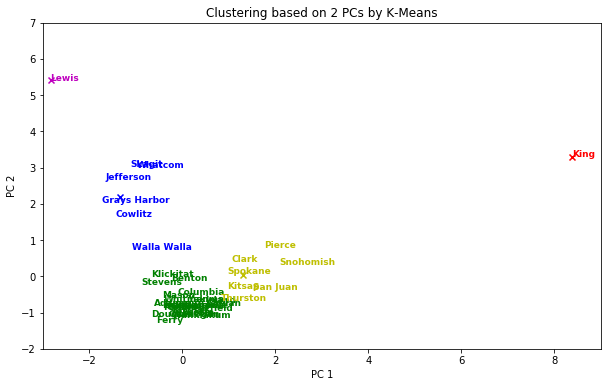

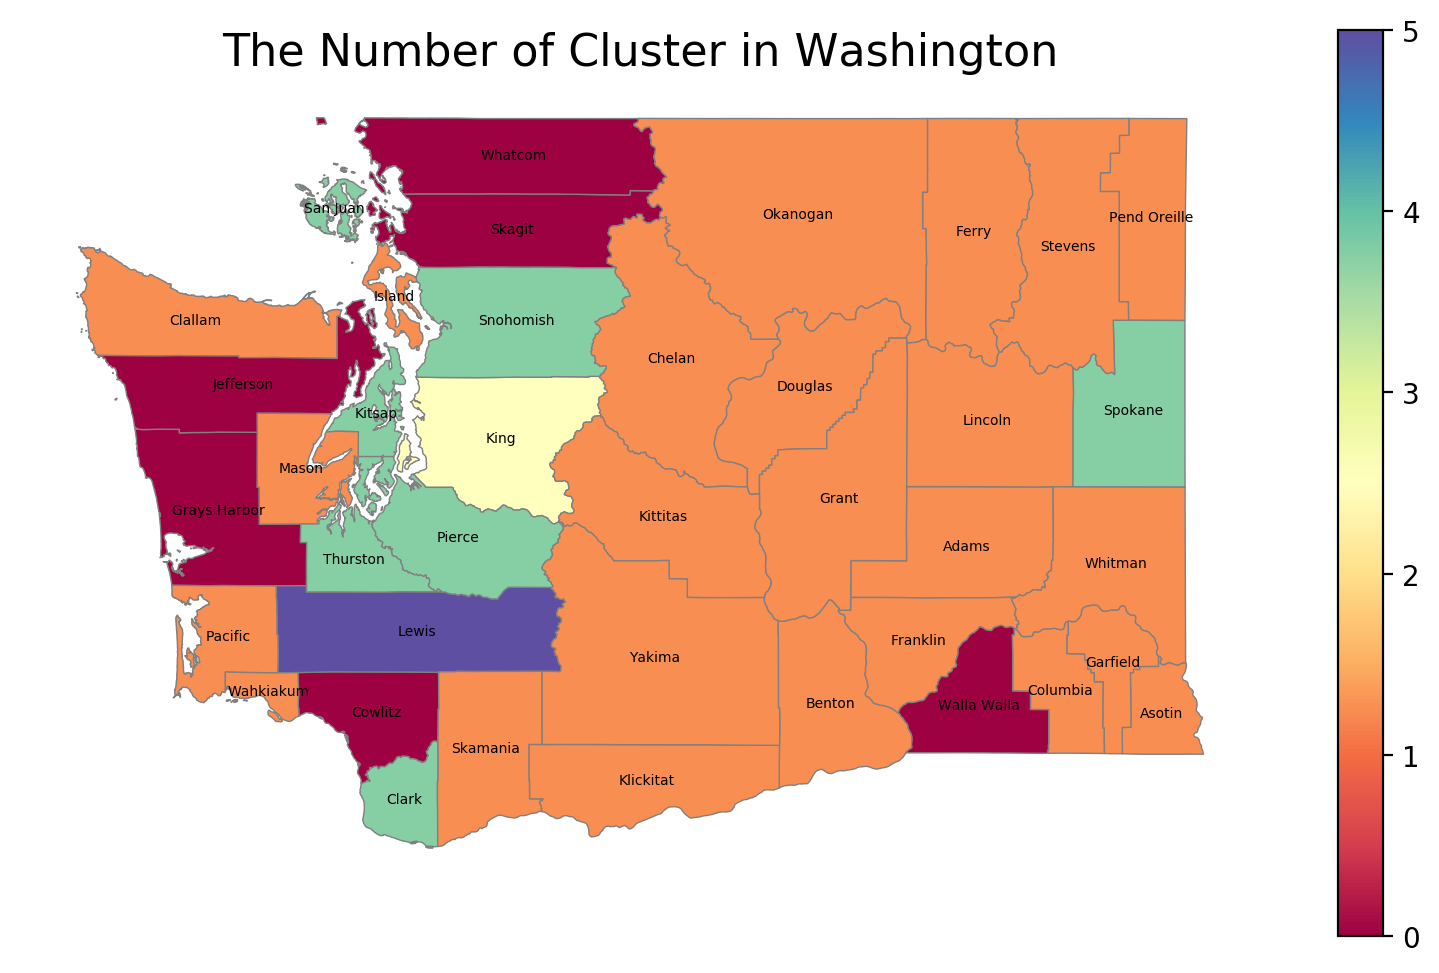

In [11]:
#K-Means
km = KMeans(n_clusters=5).fit(T[:,:2])
cents=km.cluster_centers_
labels=km.labels_
Washington_2019['Cluster']=labels
colors = ['b','g','r','y','m']
n_clusters=5
plt.figure(figsize=(10,6))
for i in range(n_clusters):
    index = np.nonzero(labels==i)[0]
    x0 = T[index,0]
    x1 = T[index,1]
    y_i = county_name[index]
    for j in range(len(x0)):
        plt.text(x0[j],x1[j],y_i[j],color=colors[i],\
                fontdict={'weight': 'bold', 'size': 9})
    plt.scatter(cents[i,0],cents[i,1],marker='x',color=colors[i],linewidths=12)
plt.axis([-3,9,-2,7])    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clustering based on 2 PCs by K-Means')
plt.savefig('K_means.png')
plt.show()

plotting_cluster(Washington_2019,'Cluster')

7. plotting every variables on the map

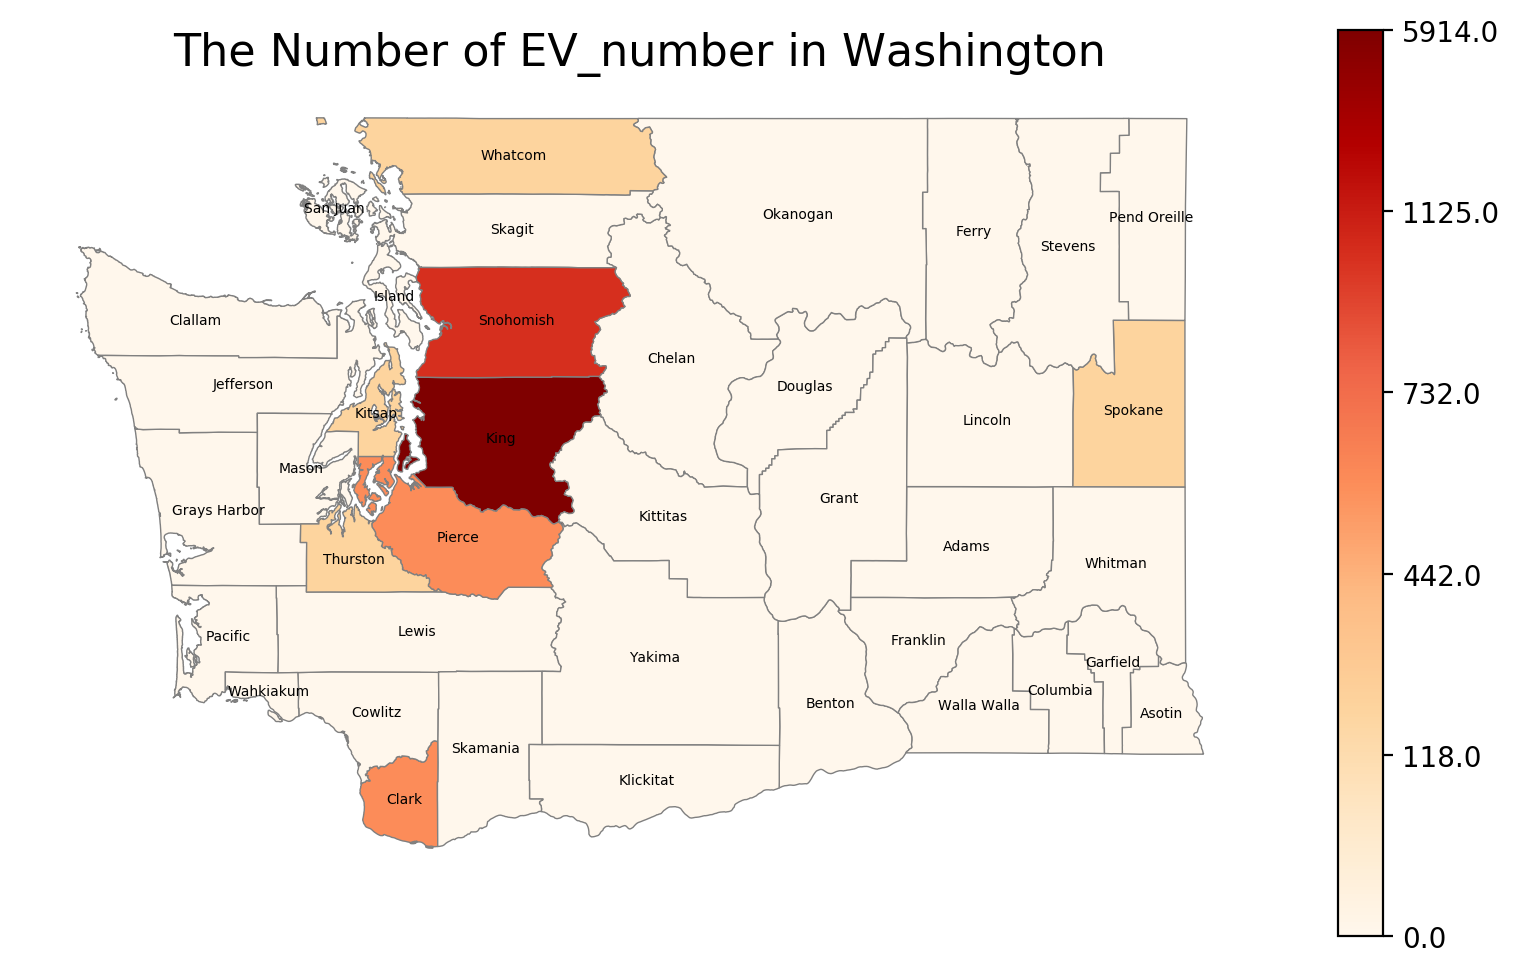

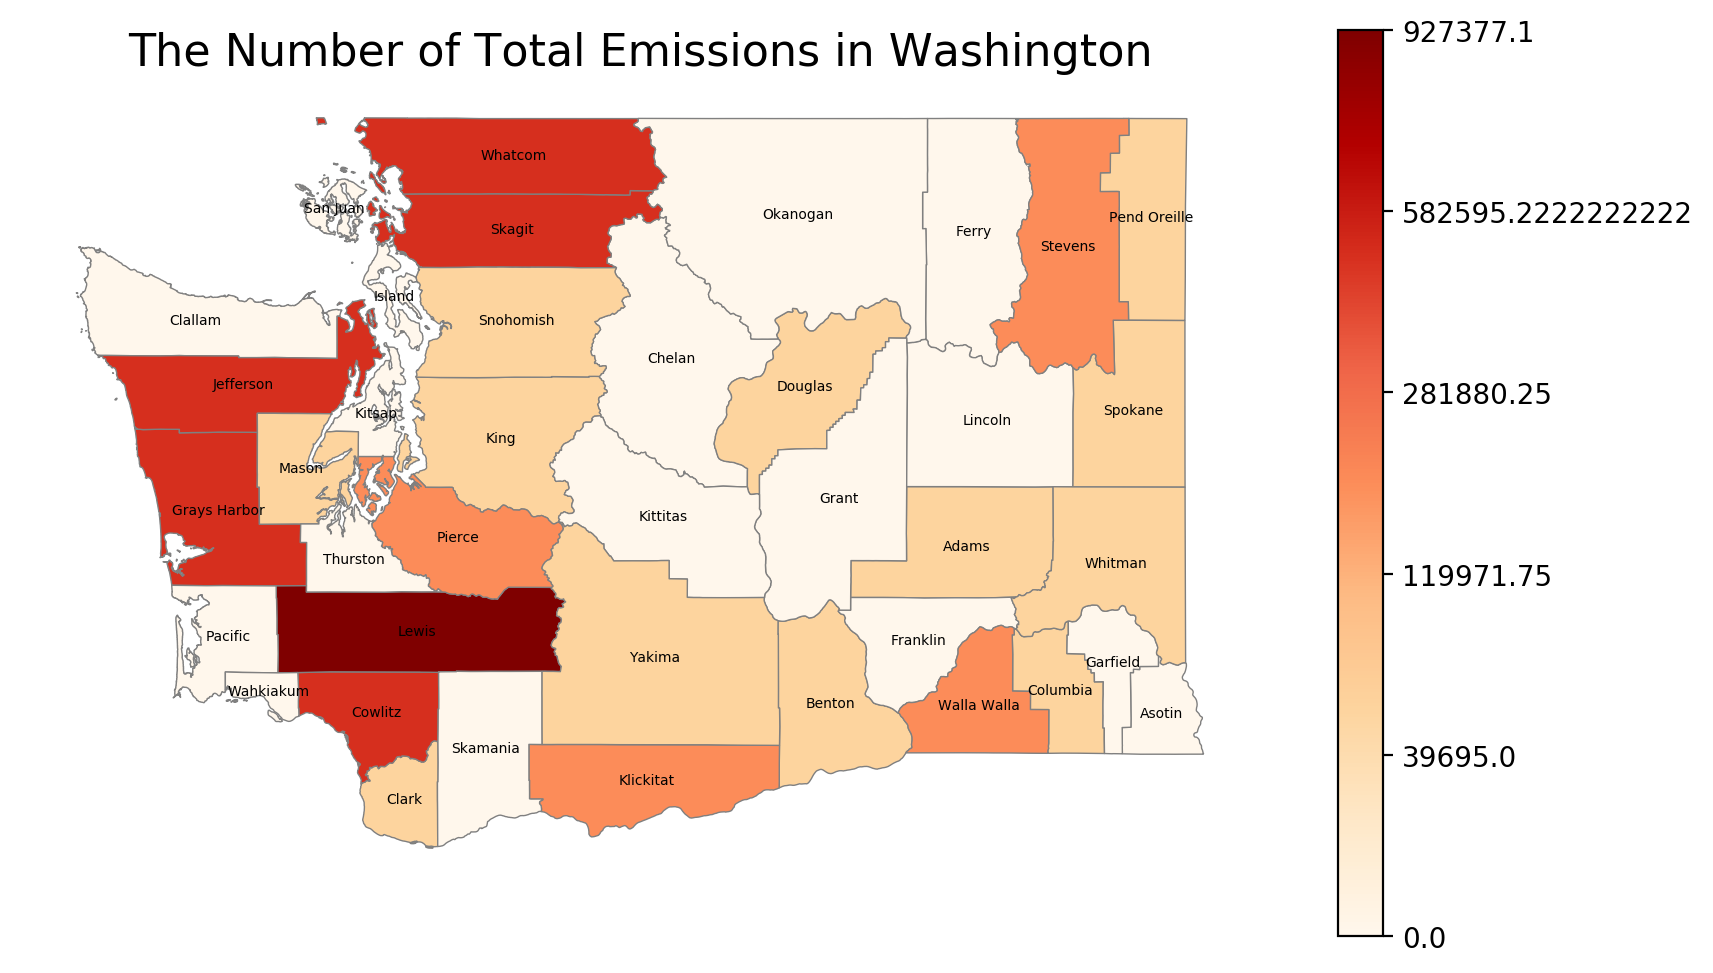

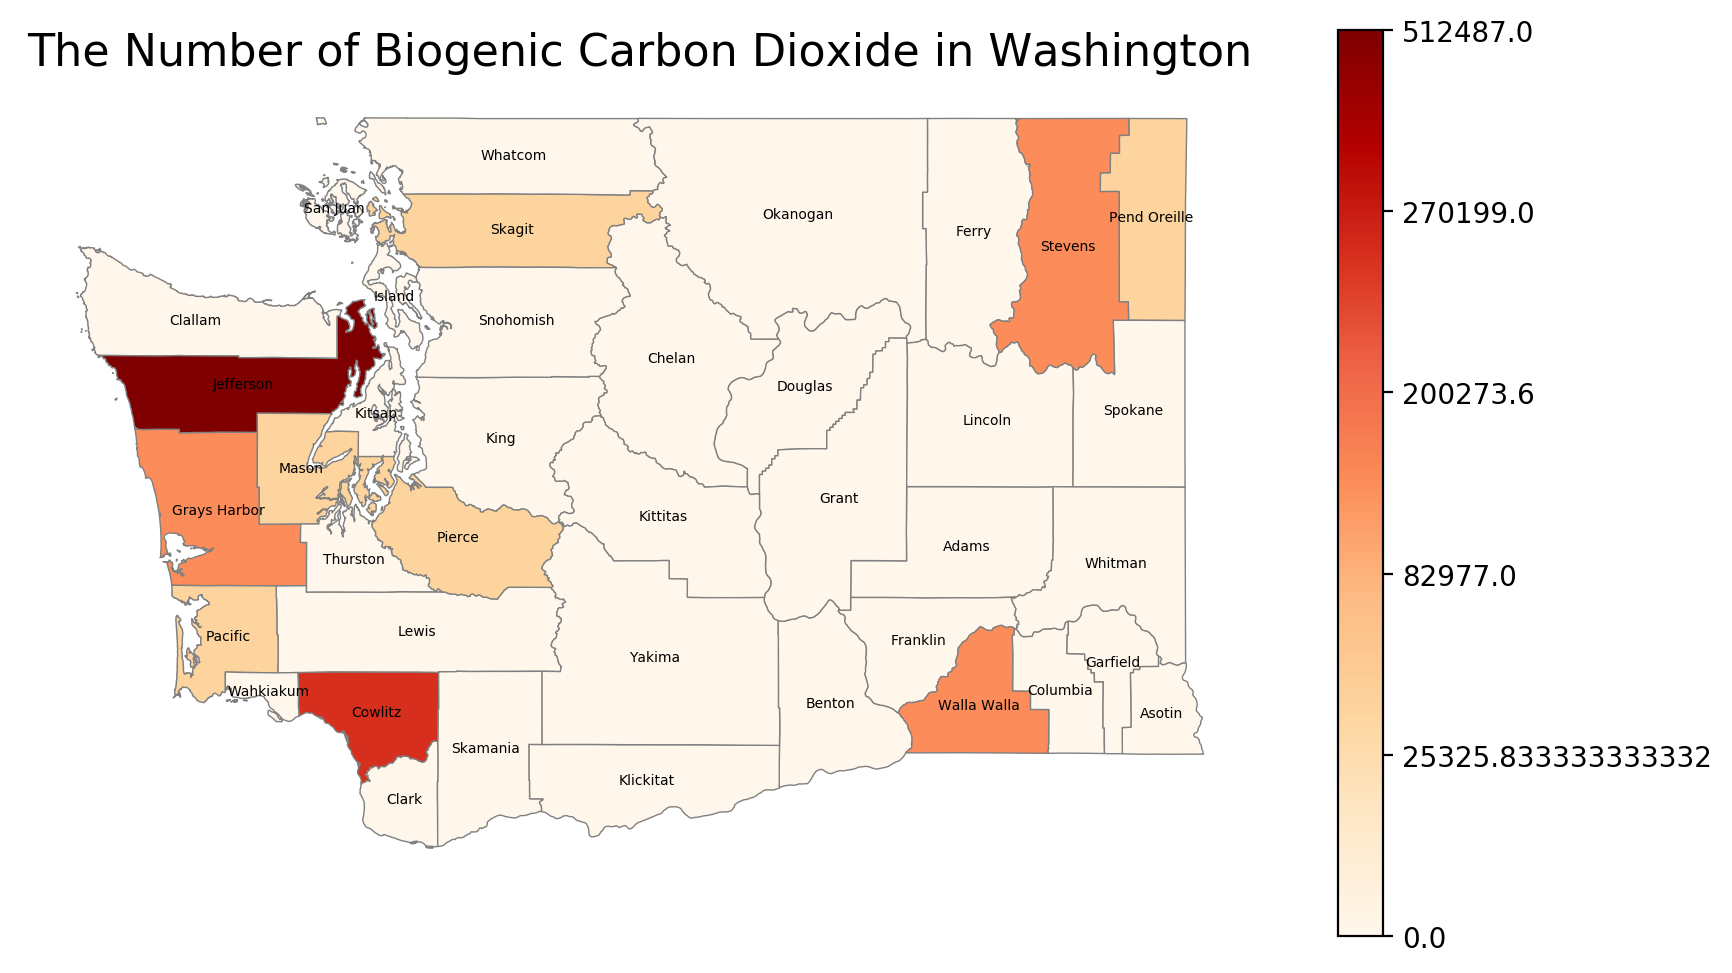

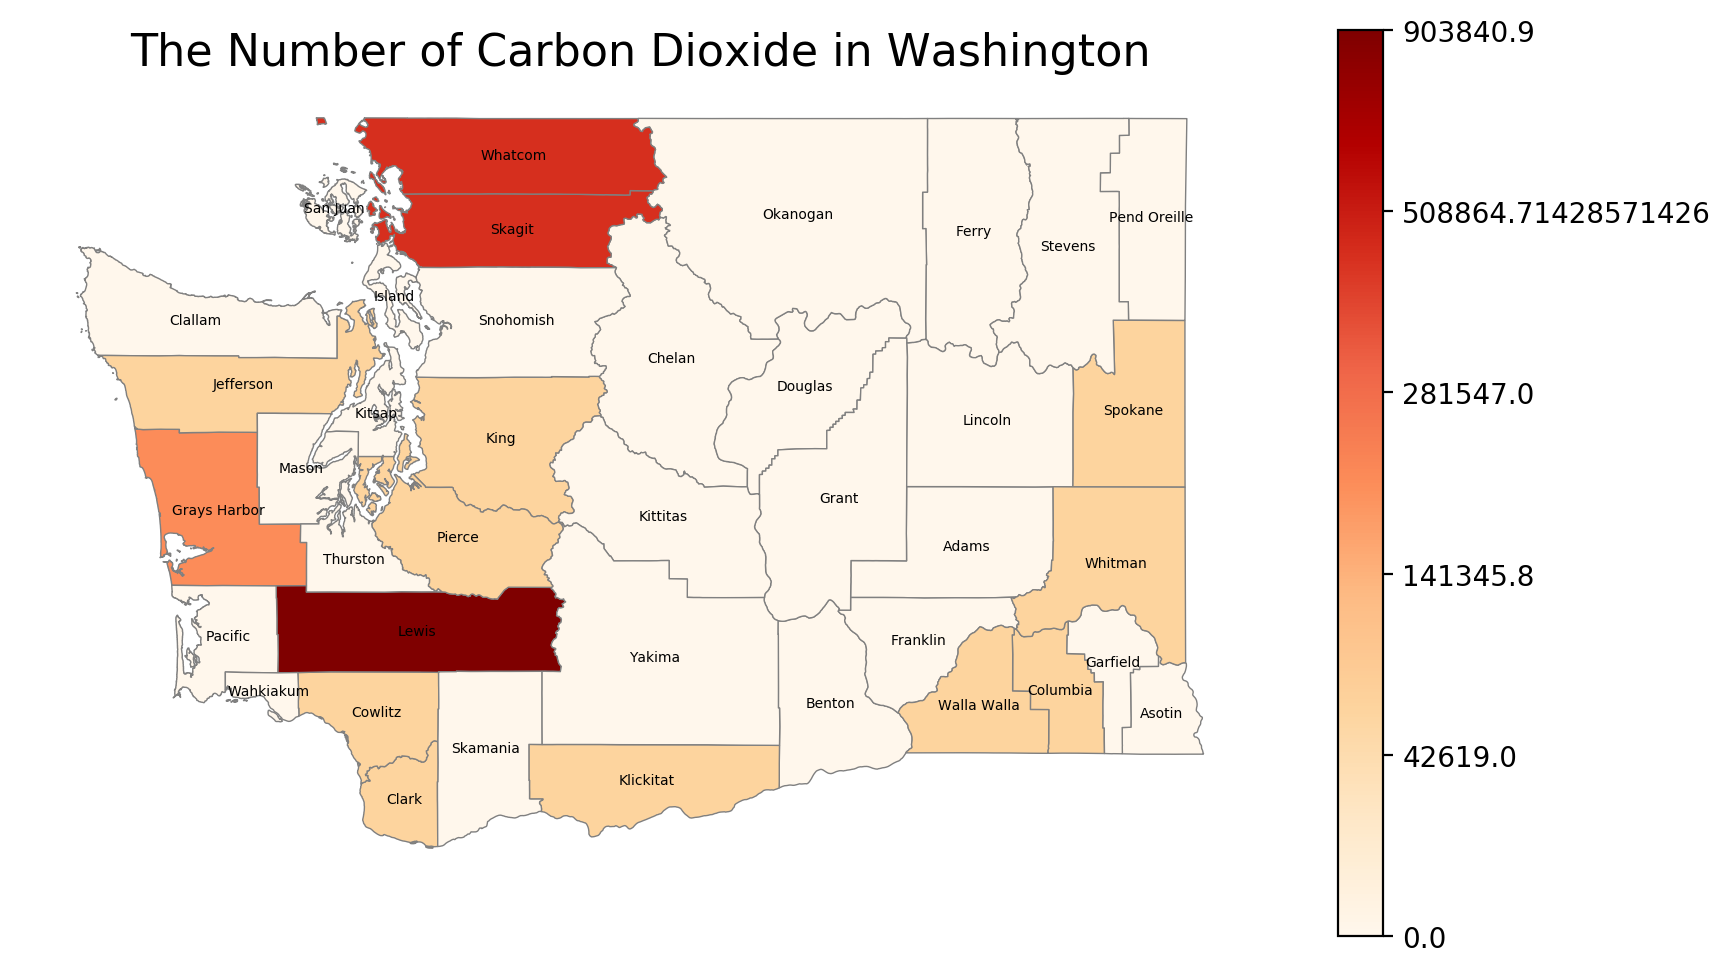

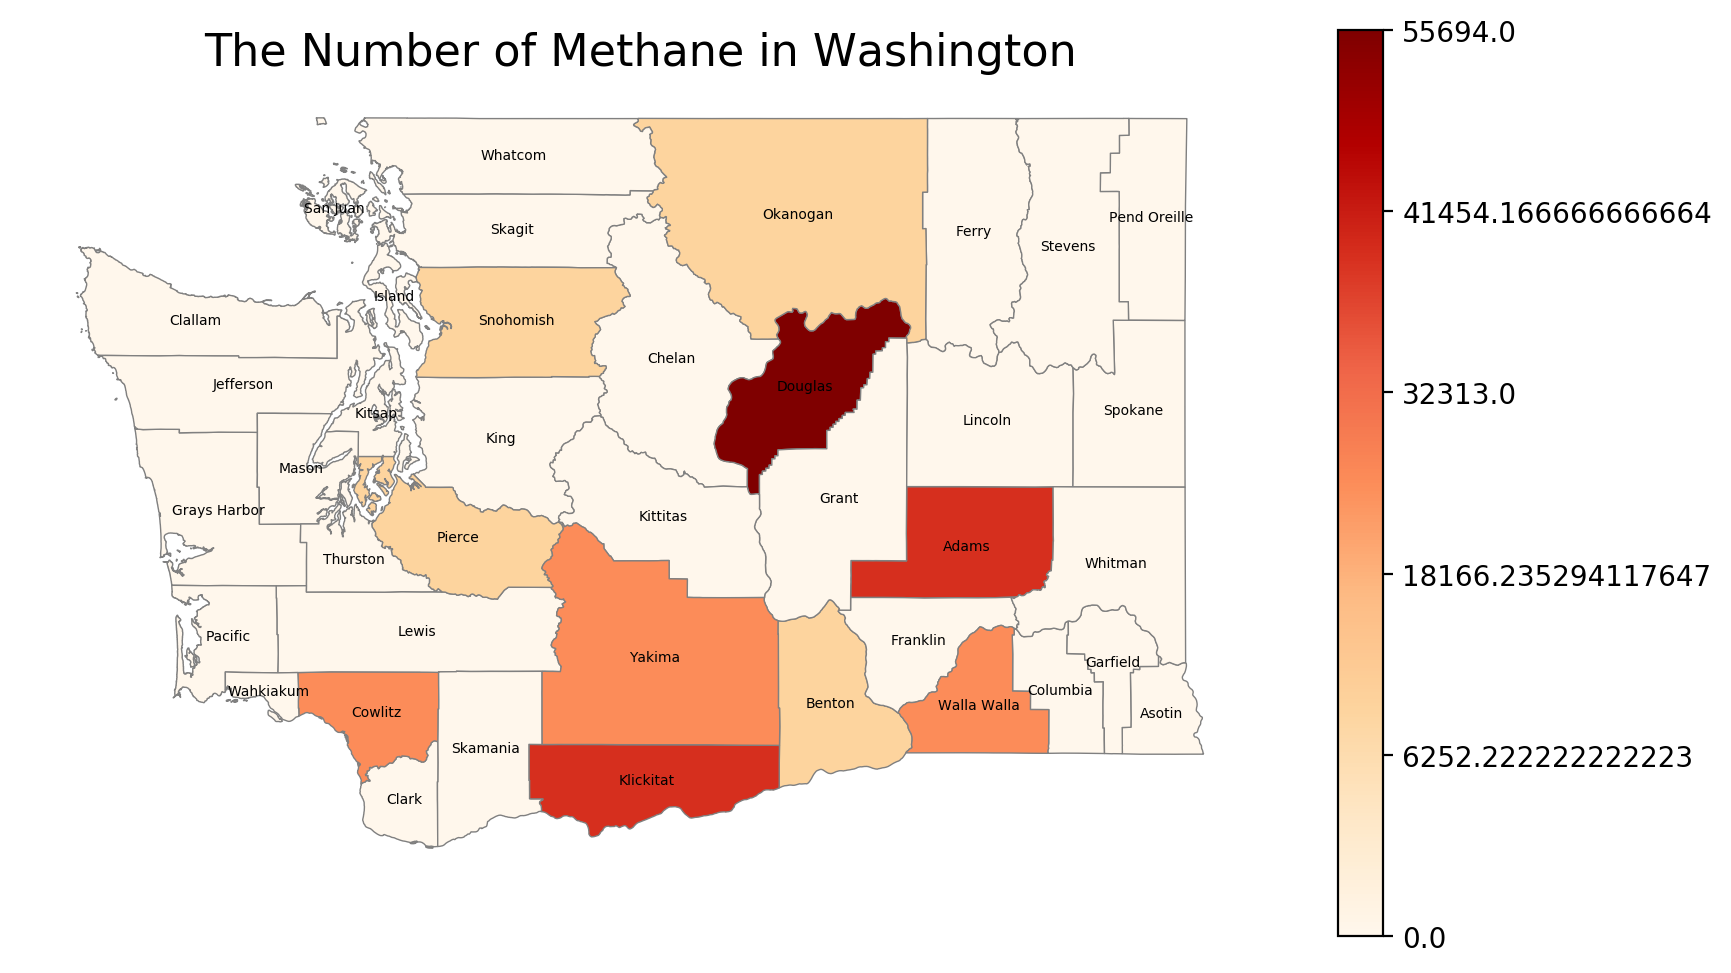

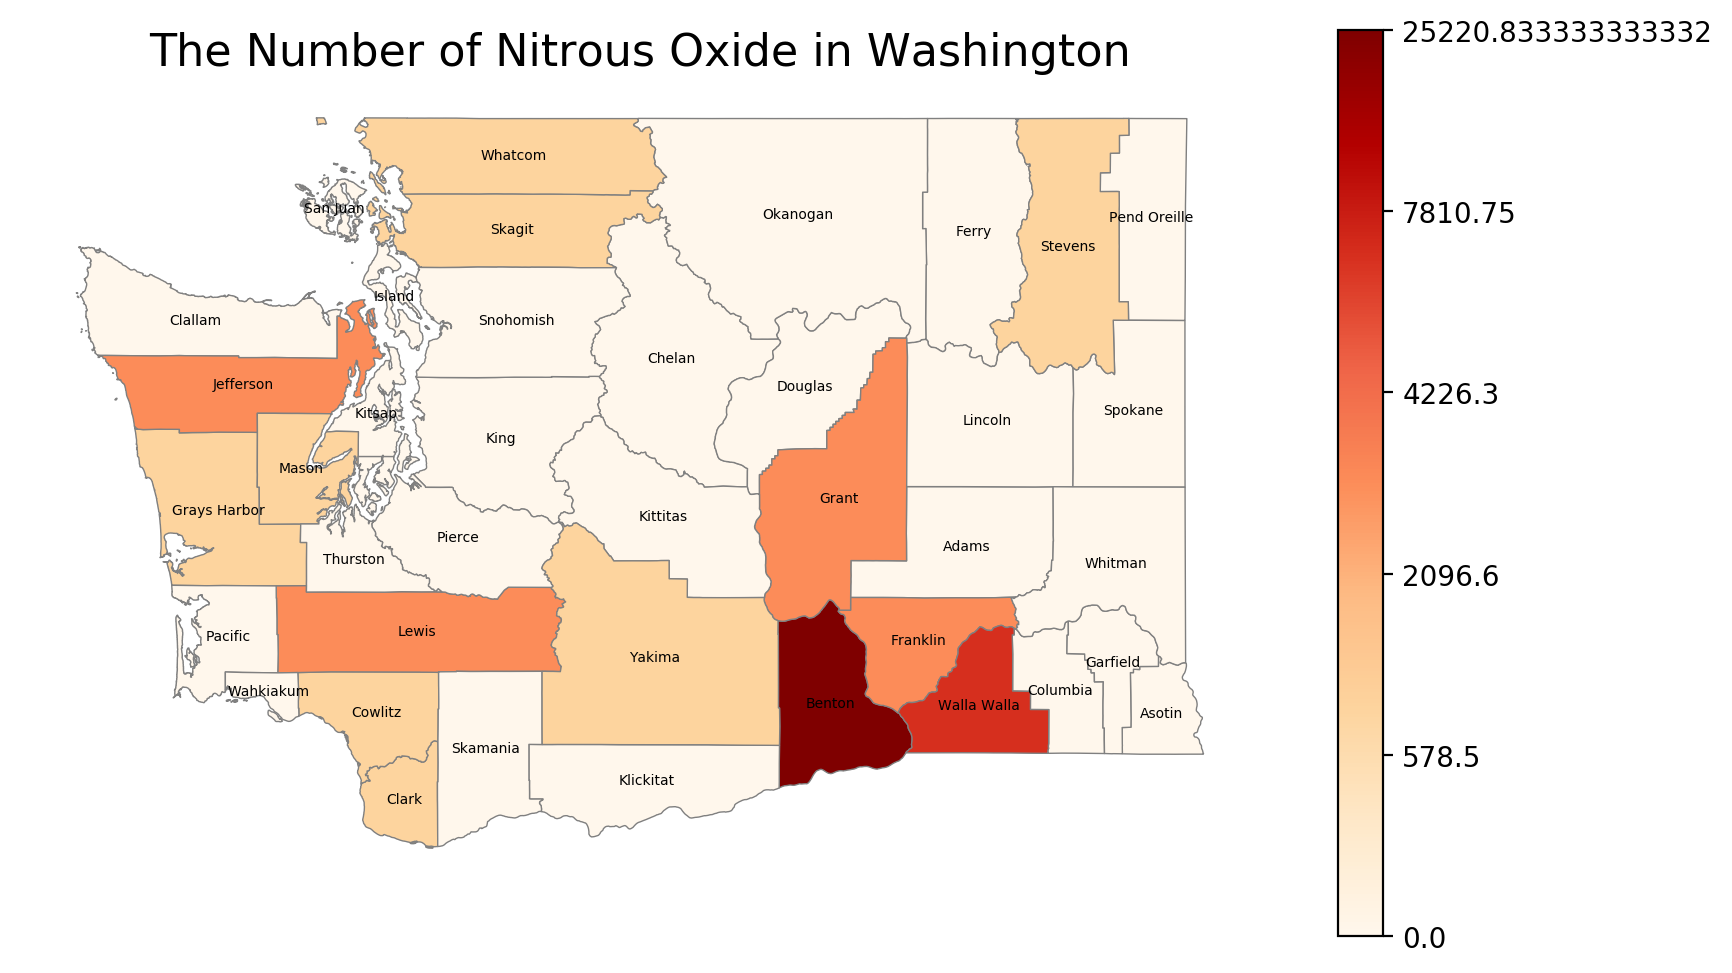

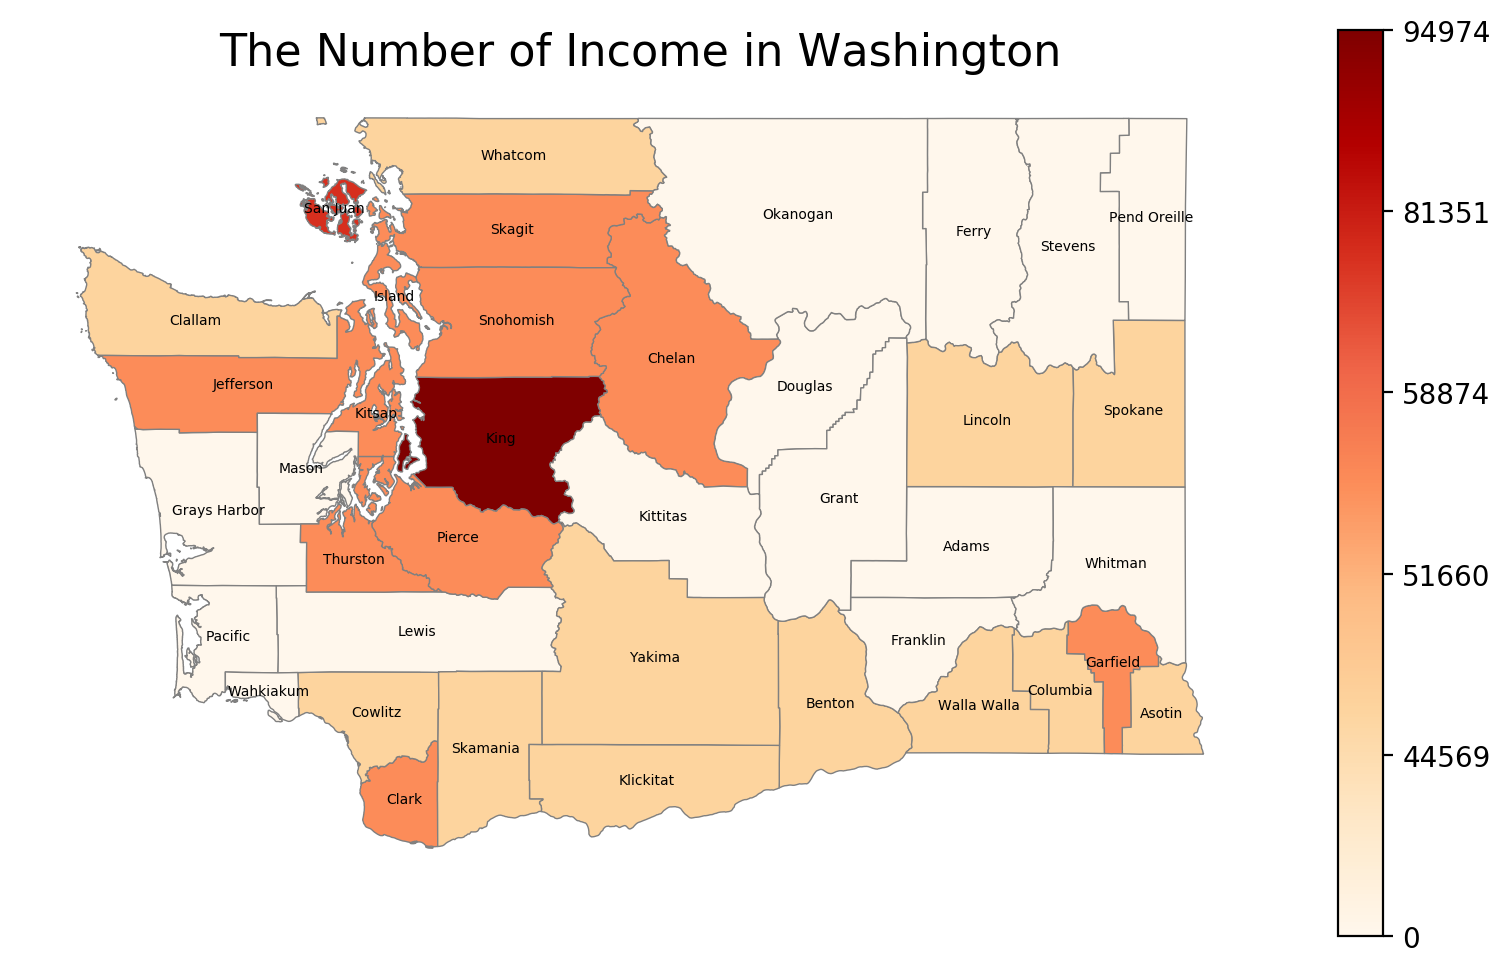

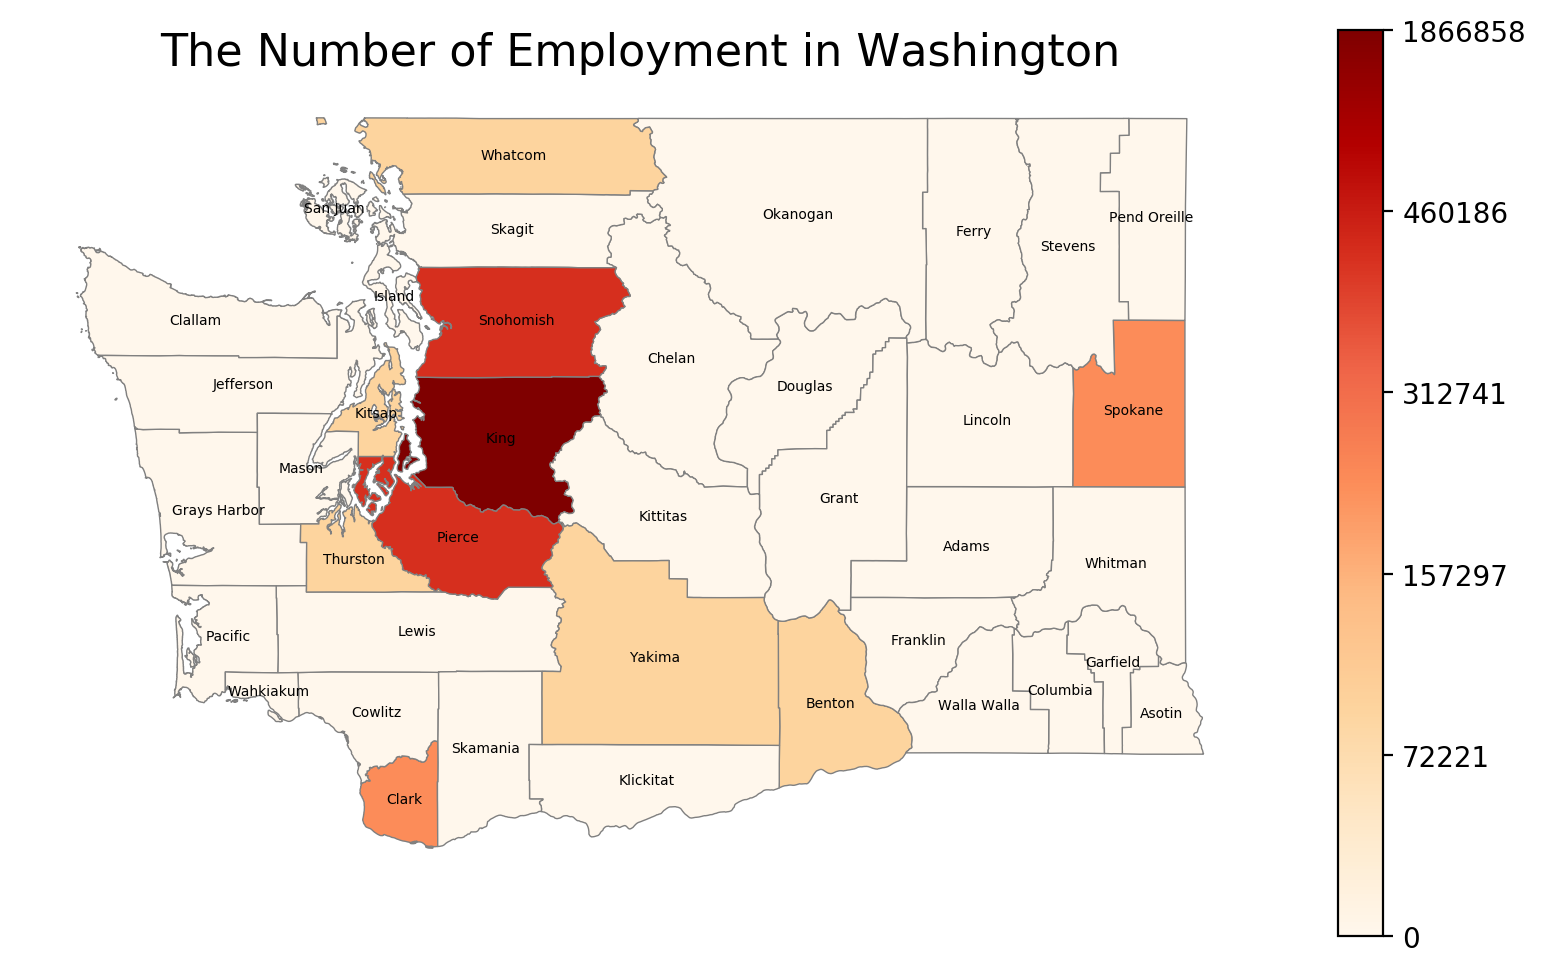

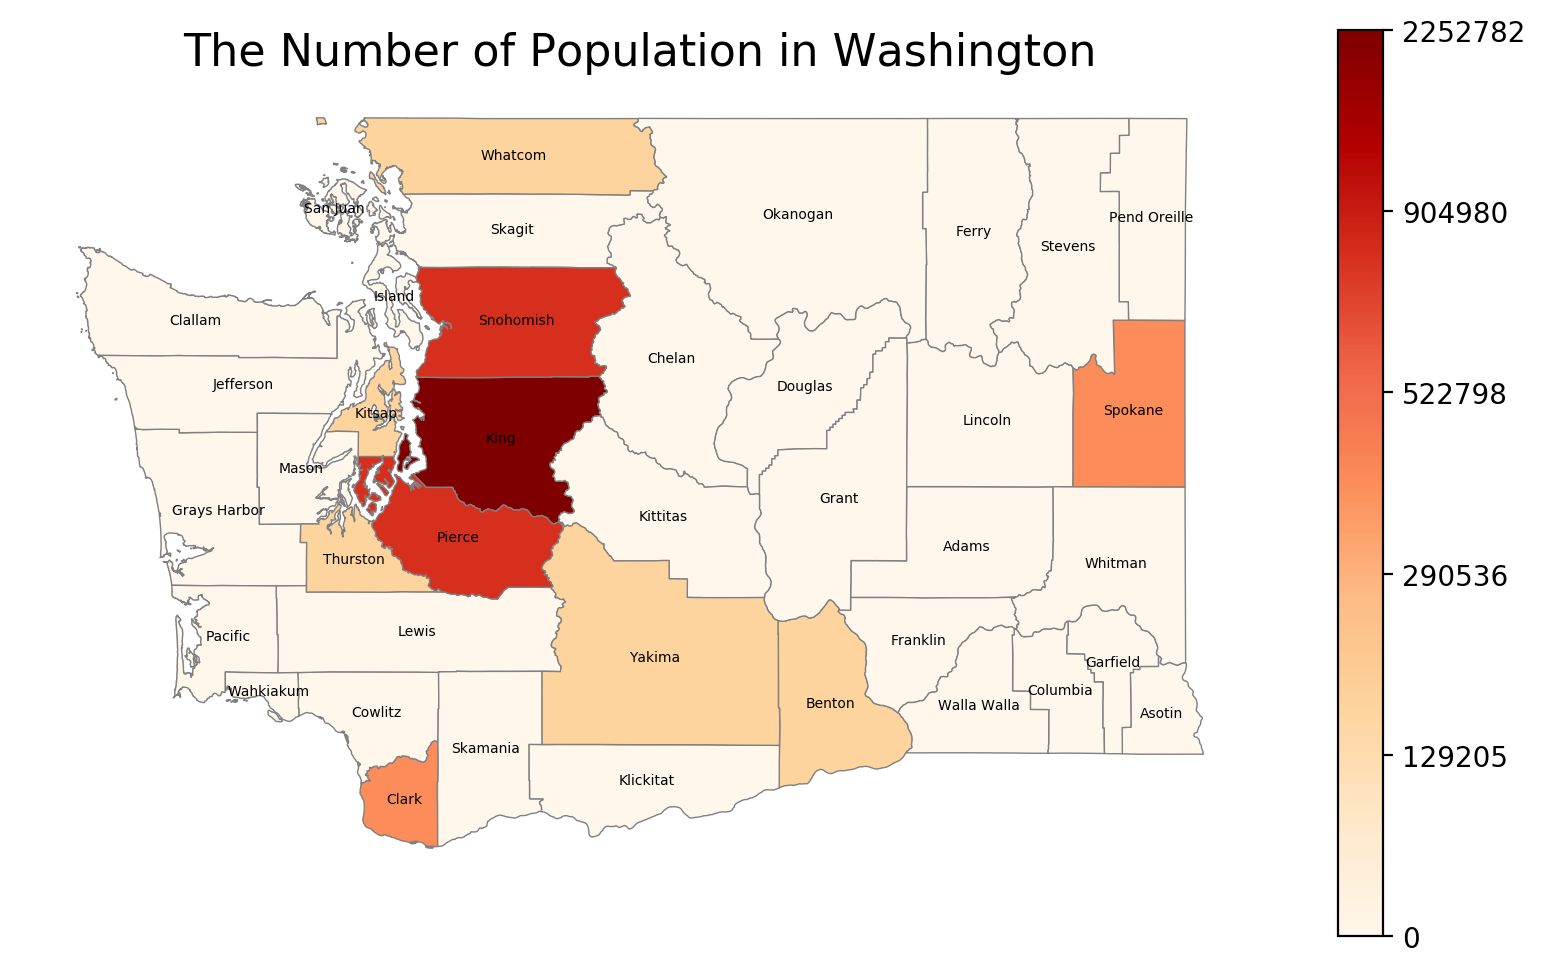

In [12]:
#Plotting
for i in range(2,11):
    plotting_map(Washington_2019,Washington_2019.columns[i])
